In [86]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [87]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1900052301.000,2019-06-04,ZB00025746,1,9.412,0.000,9.412,0.000,9.412,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1900100835.000,2019-07-15,ZB00025746,1,8.649,5.393,8.649,5.393,3.255,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1900106577.000,2019-07-24,ZB00025746,1,8.649,5.459,8.649,5.459,3.190,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1900111398.000,2019-08-01,ZB00025746,1,8.649,5.440,8.649,5.440,3.209,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1900052301.000,2019-06-04,ZB00022010,1,12.785,4.088,12.785,4.088,8.697,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [32]:
data_czech=data[data['country']=='Czech Republic']
data_czech.shape

(498832, 16)

In [33]:
data_runningshoes=data_czech[data_czech['group1']=='Running shoes']
data_runningshoes.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
488349,1900078405.000,2019-06-04,ZB00025791,1,73.996,0.000,73.996,0.000,73.996,Czech Republic,NIKE ODYSSEY REACT 2 FLYKNIT,ah1015-003,Nike,Footwear,Running shoes,running
488366,1900086051.000,2019-06-17,ZB00023061,1,107.598,0.000,107.598,0.000,107.598,Czech Republic,UltraBOOST 19,b37707,adidas,Footwear,Running shoes,running
488367,1900106717.000,2019-07-25,ZB00023061,1,107.598,52.540,107.598,52.540,55.059,Czech Republic,UltraBOOST 19,b37707,adidas,Footwear,Running shoes,running
488368,2000023084.000,2020-01-25,ZB00023061,1,115.286,52.540,115.286,52.540,62.747,Czech Republic,UltraBOOST 19,b37707,adidas,Footwear,Running shoes,running
488491,1900085863.000,2019-06-14,ZB00005936,1,44.942,41.944,44.942,41.944,2.998,Czech Republic,ASICS GEL-PULSE 10,1011a007-021,Asics,Footwear,Running shoes,running


In [35]:
data_runningshoes.shape

(36672, 16)

In [34]:
data_runningshoes['name'].value_counts()

Nike            19815
adidas           3920
Asics            3500
Salomon          3245
Under Armour     1796
INOV-8           1361
On Running        719
Mizuno            692
Hoka One One      437
Saucony           435
Puma              300
Altra             210
New Balance       153
Craft              44
Brooks             29
North Face          7
Reebok              6
La Sportiva         3
Name: name, dtype: int64

In [36]:
data_Nike=data_runningshoes[data_runningshoes['name']=='Nike']
data_Nike.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
488349,1900078405.000,2019-06-04,ZB00025791,1,73.996,0.000,73.996,0.000,73.996,Czech Republic,NIKE ODYSSEY REACT 2 FLYKNIT,ah1015-003,Nike,Footwear,Running shoes,running
491493,1900102825.000,2019-07-18,ZB00008276,1,55.897,37.876,55.897,37.876,18.021,Czech Republic,WMNS NIKE ODYSSEY REACT,ao9820-001,Nike,Footwear,Running shoes,running
491714,1900081569.000,2019-06-04,ZB00004823,1,89.692,64.027,89.692,64.027,25.665,Czech Republic,W NIKE ZOOM FLY FLYKNIT,ar4562-201,Nike,Footwear,Running shoes,running
491716,1900163942.000,2019-10-06,ZB00004823,1,89.660,79.090,89.660,79.090,10.570,Czech Republic,W NIKE ZOOM FLY FLYKNIT,ar4562-201,Nike,Footwear,Running shoes,running
491717,1900165572.000,2019-10-08,ZB00004823,1,83.285,79.090,83.285,79.090,4.195,Czech Republic,W NIKE ZOOM FLY FLYKNIT,ar4562-201,Nike,Footwear,Running shoes,running


In [37]:
data_Nike.shape

(19815, 16)

In [23]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [38]:
daily_sales=select_series(data_Nike)
daily_sales.columns=['ds', 'y']
daily_sales.ds=pd.to_datetime(daily_sales['ds'])
daily_sales.sort_values('ds')
daily_sales.head()

,ds,y
0,2019-06-01,422.736
1,2019-06-02,89.596
2,2019-06-03,63.425
3,2019-06-04,4313.377
4,2019-06-05,5145.303


In [25]:
daily_sales.to_csv(r'Nikeshoes_dailysales.csv')

In [26]:
sales=pd.read_csv('Nikeshoes_dailysales.csv')
sales=sales.drop(['Unnamed: 0'], axis=1)
sales.columns=['date', 'sales']
sales.head()

,date,sales
0,2019-06-01,422.736
1,2019-06-02,89.596
2,2019-06-03,63.425
3,2019-06-04,4313.377
4,2019-06-05,5145.303


In [27]:
# convert date column to datatime object
sales['date'] = pd.to_datetime(sales['date'], format='%Y-%m-%d') 


# Create Date-related Features for EDA and modeling
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['weekday'] = sales['date'].dt.weekday
sales['weekday'] = np.where(sales.weekday == 0, 7, sales.weekday)
sales.head()

,date,sales,year,month,day,weekday
0,2019-06-01,422.736,2019,6,1,5
1,2019-06-02,89.596,2019,6,2,6
2,2019-06-03,63.425,2019,6,3,7
3,2019-06-04,4313.377,2019,6,4,1
4,2019-06-05,5145.303,2019,6,5,2


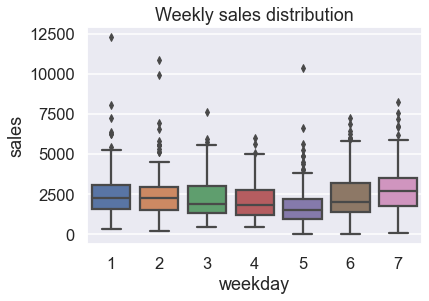

In [39]:
#let's find out the usual sales during a week

plot = sns.boxplot(x='weekday', y='sales', data=sales)
_ = plot.set(title='Weekly sales distribution')

#### It seems like the sales peak is on Sundays (day 7), and it is followed by Mondays.

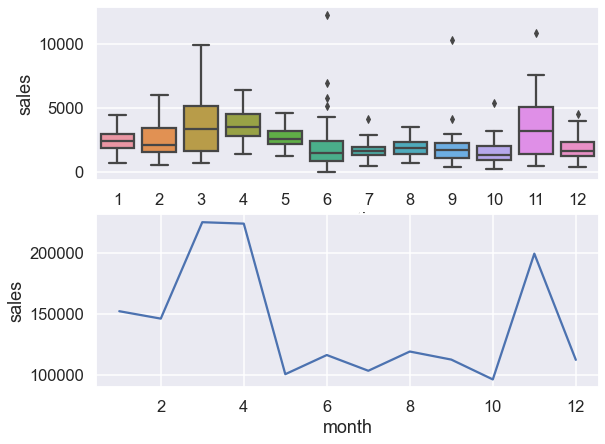

In [41]:
# let's see how monthly sales looks like in a year. 
monthly_agg = sales.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='sales', data=sales, ax=axs[0])
_ = sns.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

In [42]:

train_df=daily_sales[:int(daily_sales.shape[0]*0.8)]

test_df=daily_sales[int(daily_sales.shape[0]*0.8):]
print(train_df.shape)
print(test_df.shape)

(565, 2)
(142, 2)


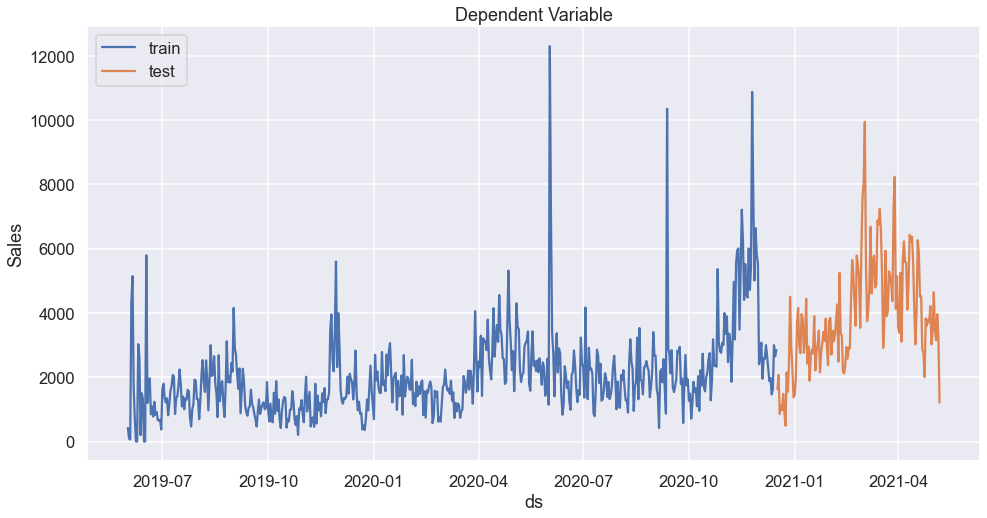

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [44]:
#training the model on training set
model=Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=3)
model.add_seasonality(name='monthly', period=30, fourier_order=1)
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [45]:
future=model.make_future_dataframe(periods=172, freq='D')
forecast=model.predict(future)

In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,1258.839,-525.899,2421.317,1258.839,1258.839,-304.297,-304.297,-304.297,139.561,139.561,139.561,-443.858,-443.858,-443.858,0.000,0.000,0.000,954.542
1,2019-06-02,1260.904,-28.128,2833.537,1260.904,1260.904,114.894,114.894,114.894,169.859,169.859,169.859,-54.964,-54.964,-54.964,0.000,0.000,0.000,1375.798
2,2019-06-03,1262.968,430.455,3303.209,1262.968,1262.968,663.965,663.965,663.965,192.733,192.733,192.733,471.232,471.232,471.232,0.000,0.000,0.000,1926.933
3,2019-06-04,1265.032,270.949,3121.407,1265.032,1265.032,425.957,425.957,425.957,207.184,207.184,207.184,218.773,218.773,218.773,0.000,0.000,0.000,1690.989
4,2019-06-05,1267.096,226.012,3127.738,1267.096,1267.096,374.161,374.161,374.161,212.580,212.580,212.580,161.582,161.582,161.582,0.000,0.000,0.000,1641.258


In [47]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,954.542,-525.899,2421.317
1,2019-06-02,1375.798,-28.128,2833.537
2,2019-06-03,1926.933,430.455,3303.209
3,2019-06-04,1690.989,270.949,3121.407
4,2019-06-05,1641.258,226.012,3127.738


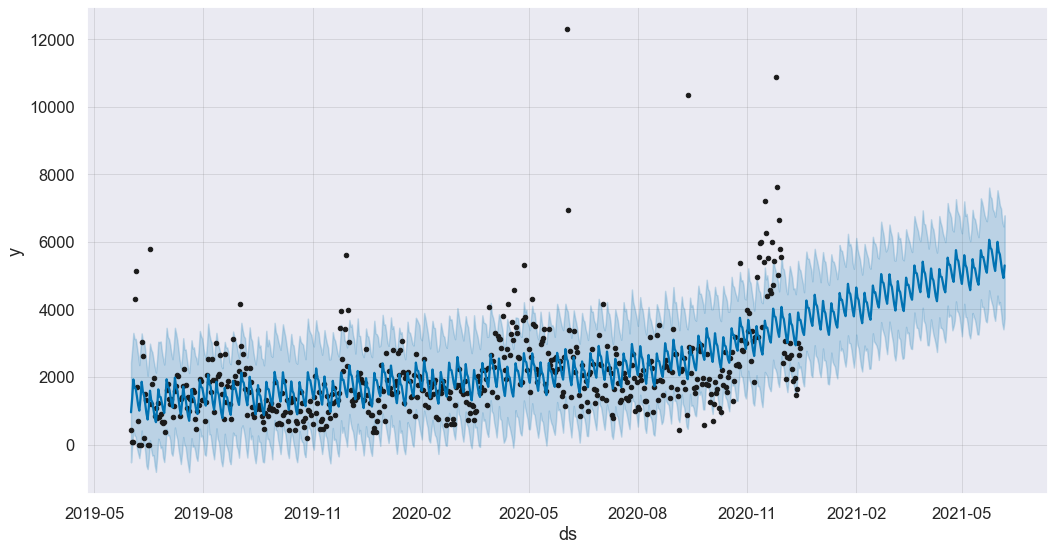

In [48]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

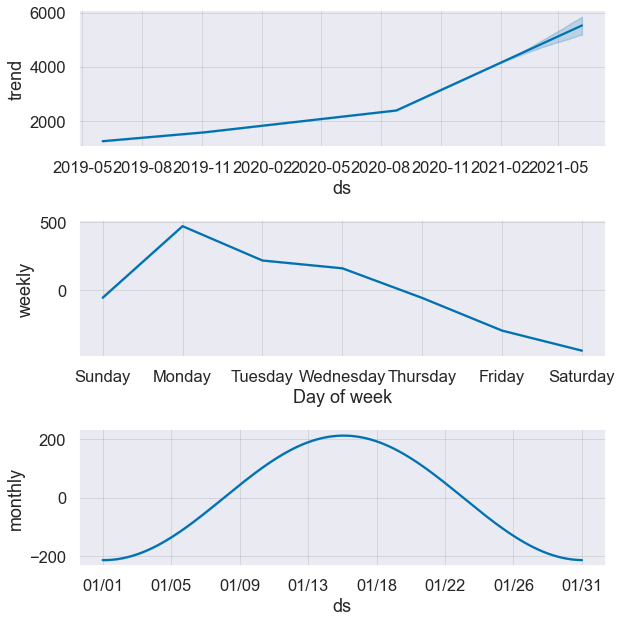

In [49]:
# ploting model components
model.plot_components(forecast)
plt.show()

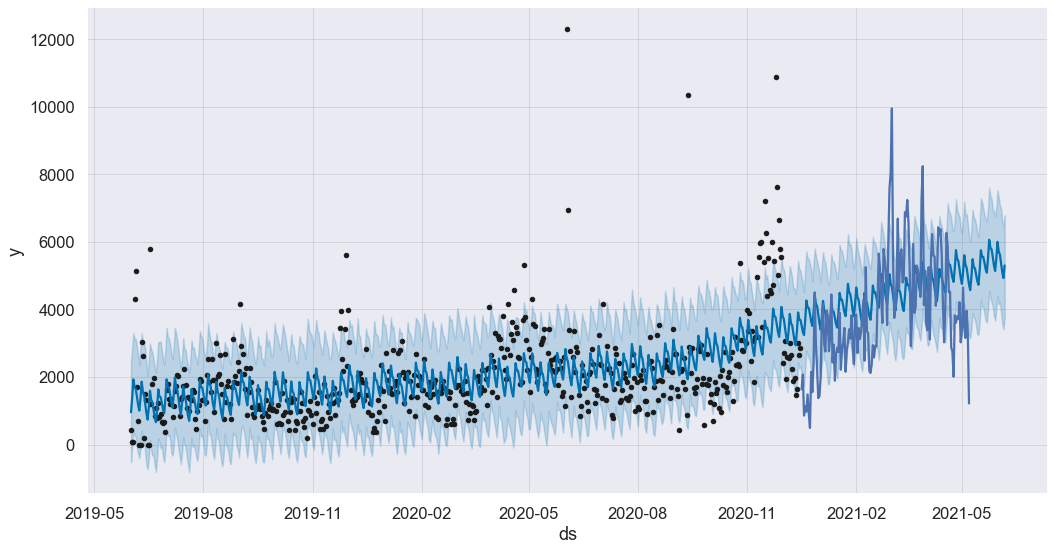

In [50]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y)



Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

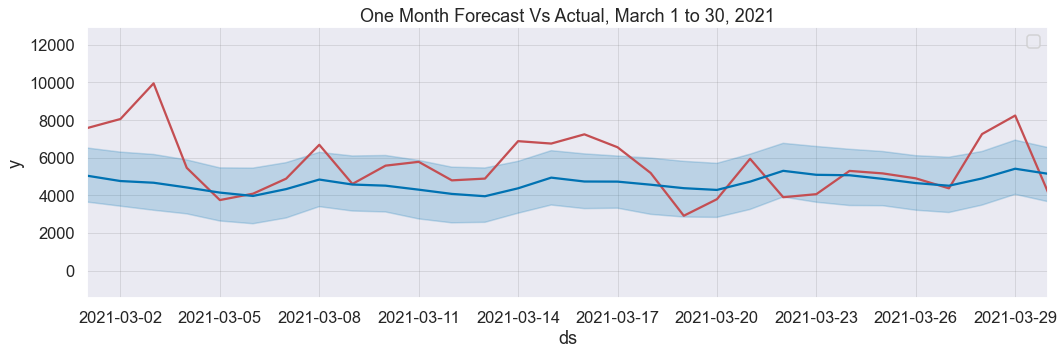

In [51]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-01', upper='2021-03-30')
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

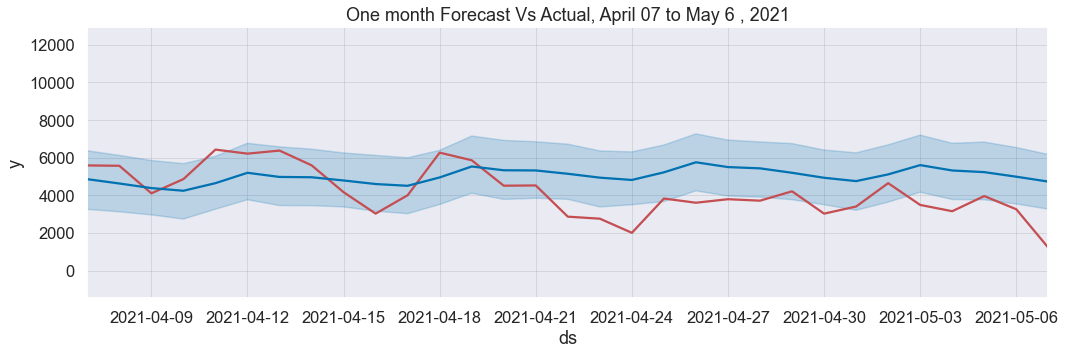

In [52]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

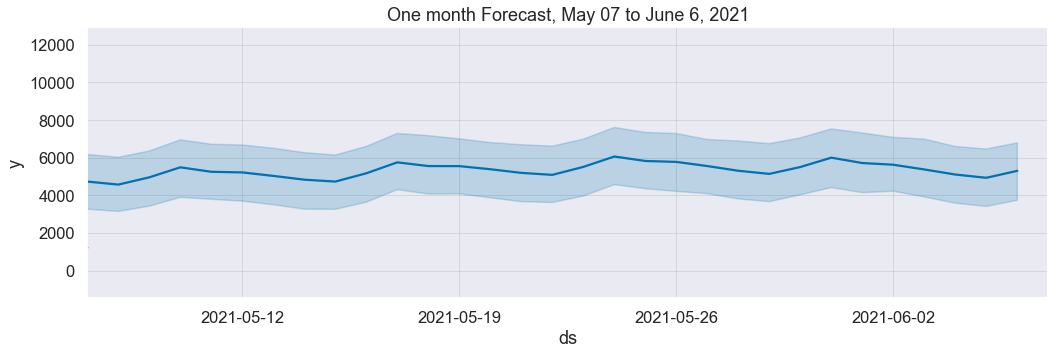

In [53]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

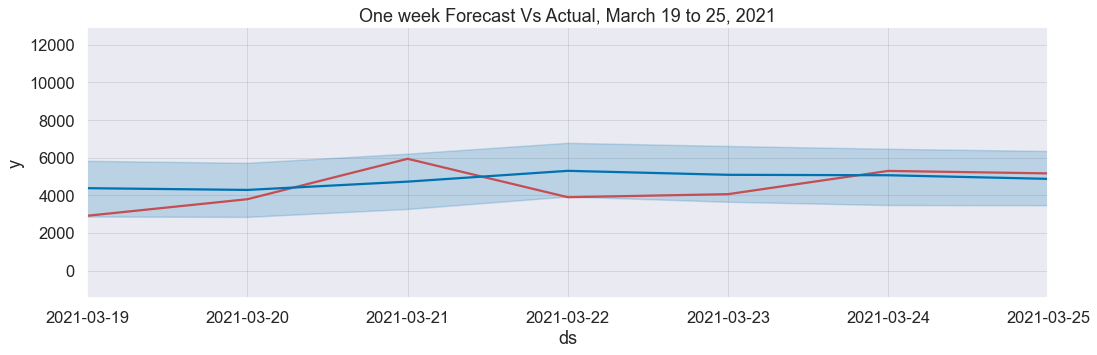

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [55]:
# Means Squared Error and RSME
predictions=forecast.yhat[-142:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='30 days', initial='90', period='30 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 18 forecasts with cutoffs between 2019-06-25 00:00:00 and 2020-11-16 00:00:00


MSE:  3088378.431111179
RMSE:  1757.3782834413253



MAPE:  53.63711704705534


In [56]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-26,1489.541,-115.360,2962.320,918.638,2019-06-25
1,2019-06-27,682.230,-824.414,2290.756,671.183,2019-06-25
2,2019-06-28,-222.155,-1811.650,1253.211,651.579,2019-06-25
3,2019-06-29,-1041.972,-2569.374,530.358,680.088,2019-06-25
4,2019-06-30,-1299.134,-2824.397,370.810,376.322,2019-06-25


In [57]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
535,2020-12-12,2256.619,862.403,3574.889,1467.007,2020-11-16
536,2020-12-13,2653.888,1375.408,3950.408,1634.602,2020-11-16
537,2020-12-14,3207.378,1935.488,4603.624,2998.879,2020-11-16
538,2020-12-15,2945.834,1609.721,4272.186,2656.321,2020-11-16
539,2020-12-16,2848.817,1580.811,4264.321,2845.730,2020-11-16


In [58]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1147118.090,1071.036,770.439,0.546,0.360,0.778
1,4 days,916883.851,957.541,666.131,0.496,0.276,0.833
2,5 days,887274.279,941.952,679.121,0.518,0.258,0.833
3,6 days,995581.085,997.788,738.238,0.524,0.293,0.759
4,7 days,1556093.213,1247.435,906.846,0.507,0.388,0.704
5,8 days,1889050.991,1374.428,1014.452,0.480,0.423,0.667
6,9 days,3117147.984,1765.545,1186.914,0.575,0.440,0.648
7,10 days,3062097.948,1749.885,1151.094,0.587,0.447,0.667
8,11 days,2864085.633,1692.361,1086.322,0.609,0.375,0.685
9,12 days,1832842.452,1353.825,923.217,0.556,0.297,0.741


Text(0.5, 1.0, ' Forecast Vs Actual')

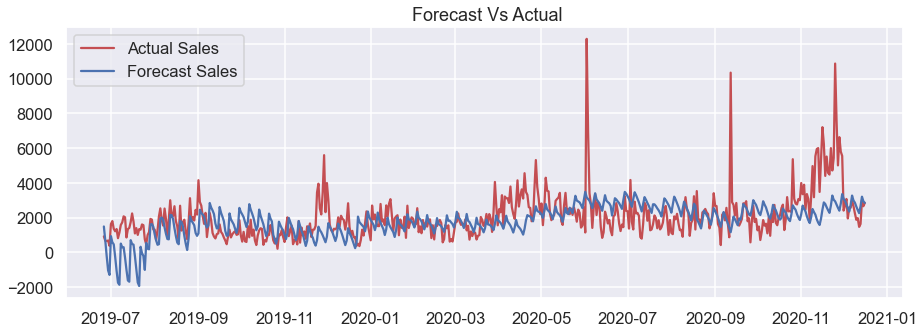

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

# Hyperparameter tuning

In [60]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 500


In [61]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781a1430>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc58774c820>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc58774c430>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781b39d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5860219d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781a1c10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781a1580>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781303d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c27ee0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781b39d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc586021fa0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c1bd00>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc587534340>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5874d4a90>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc59143fa00>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc59179a3a0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5859e4c10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5913f5910>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585ba3ee0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c7d790>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5874d4a90>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5875349d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5874d40a0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781306d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c39940>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5874c5ca0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc59118c2b0>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc59179abe0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc58772dd00>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5913f5490>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c39940>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c7d790>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc578156070>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc585c39940>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781a10d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5874c5ca0>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc587b82070>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781a1580>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc5781306d0>
INFO:fbprophet:Disabling yearly seaso

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                    0.010   
1     multiplicative                    0.001                    0.010   
2     multiplicative                    0.001                    0.010   
3     multiplicative                    0.001                    0.010   
4     multiplicative                    0.001                    0.010   
..               ...                      ...                      ...   
315         additive                    0.500                   10.000   
316         additive                    0.500                   10.000   
317         additive                    0.500                   10.000   
318         additive                    0.500                   10.000   
319         additive                    0.500                   10.000   

     n_changepoints     rmse  
0                 3  739.664  
1                 6  876.802  
2                 

In [74]:

tuning_results.sort_values(by=['rmse'])

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
213,additive,0.010,0.100,12,672.049
57,multiplicative,0.010,0.100,24,674.359
67,multiplicative,0.010,1.000,24,674.678
77,multiplicative,0.010,10.000,24,677.352
224,additive,0.010,1.000,15,678.621
...,...,...,...,...,...
292,additive,0.500,0.100,9,1082.577
147,multiplicative,0.500,1.000,24,1082.924
282,additive,0.500,0.010,9,1084.352
302,additive,0.500,1.000,9,1084.615


In [75]:
final_model=Prophet(growth='linear', daily_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=0.10, changepoint_prior_scale=0.010, n_changepoints=12)
final_model.add_seasonality(name='monthly', period=30, fourier_order=1)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [76]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+30, freq='D')
final_forecast=final_model.predict(future)

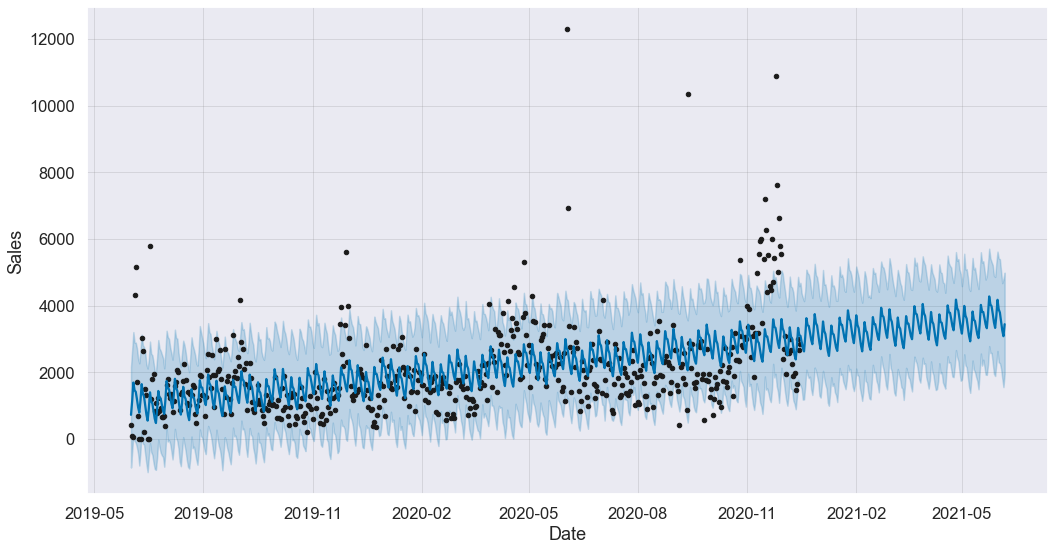

In [77]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

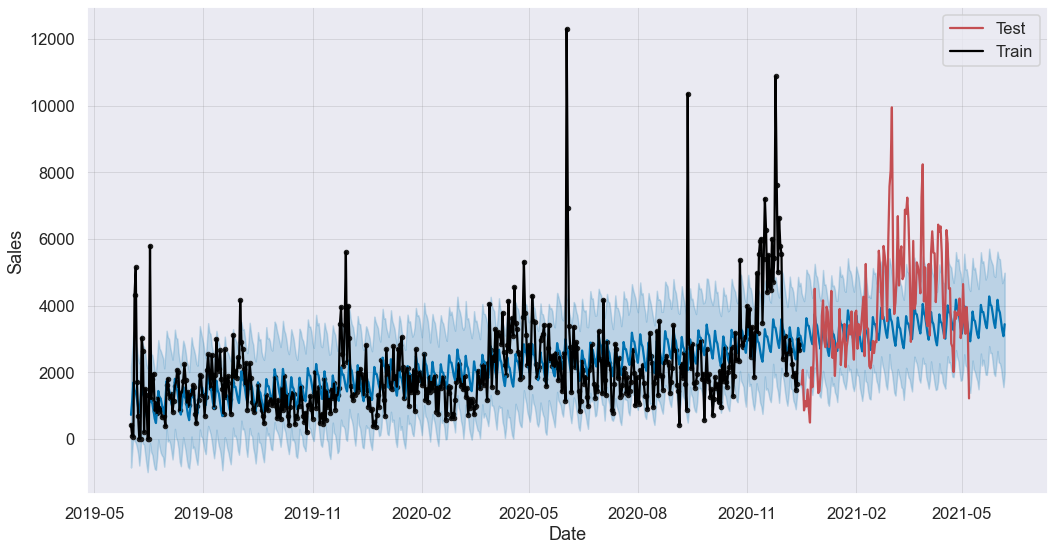

In [78]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

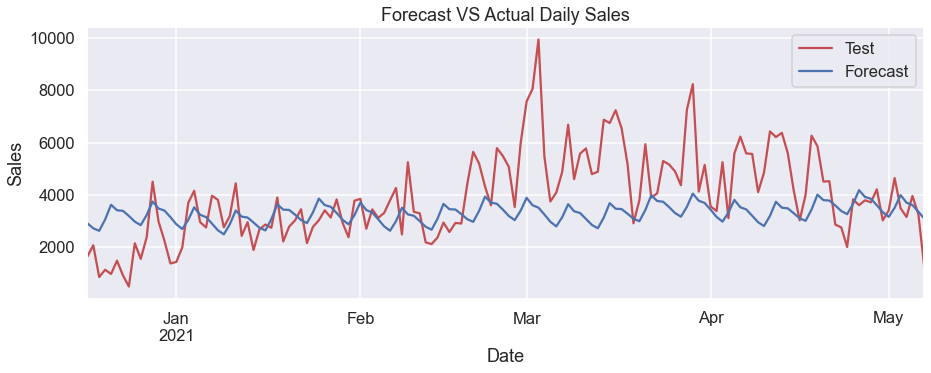

In [79]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [80]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  38.97643783559989


Text(0.5, 1.0, 'One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

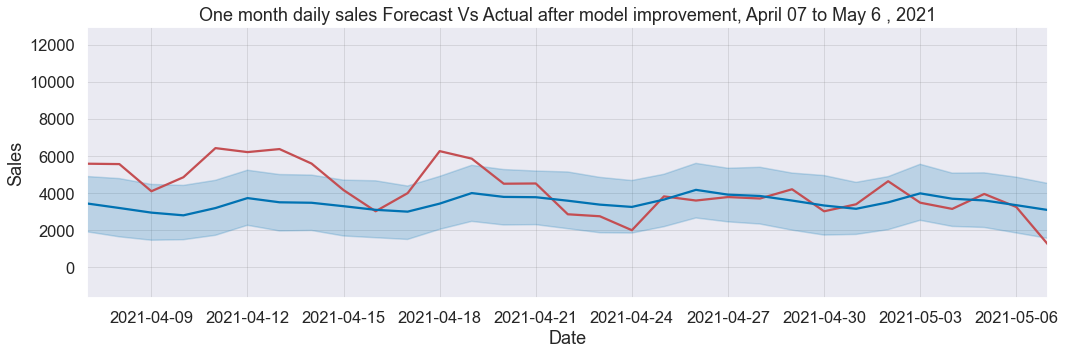

In [81]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

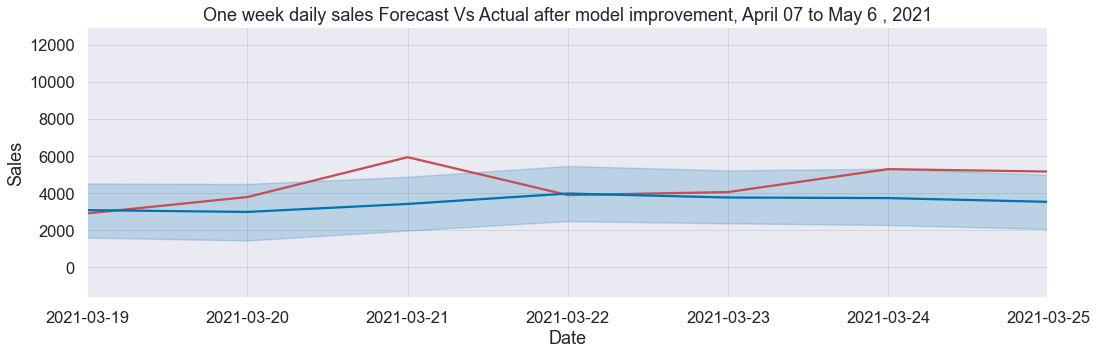

In [82]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

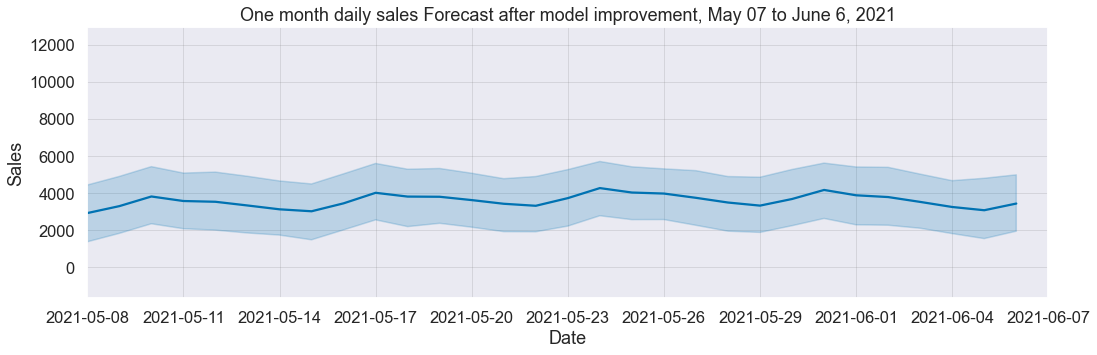

In [83]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-08', upper='2021-06-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

In [84]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-01,954.542,723.243
1,2019-06-02,1375.798,1142.754
2,2019-06-03,1926.933,1691.318
3,2019-06-04,1690.989,1460.436
4,2019-06-05,1641.258,1414.470


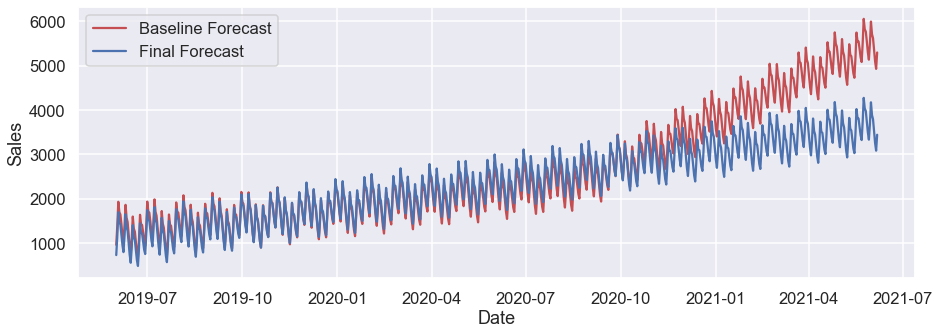

In [85]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

